In [1]:
# Dataframe
import pandas as pd

# Numeric Functions
import numpy as np
from scipy import stats
from scipy.stats import norm, skew
from scipy.stats.stats import pearsonr

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Modeling
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# Training
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_orig = pd.read_csv("../data/train.csv")
test_orig = pd.read_csv("../data/test.csv")

In [3]:
both = pd.concat((train_orig.drop(["SalePrice"], axis = 1), test_orig))

# Analysis of the Missing Values

In [4]:
train_orig.shape

(1460, 81)

In [5]:
test_orig.shape

(1459, 80)

In [6]:
both.shape

(2919, 80)

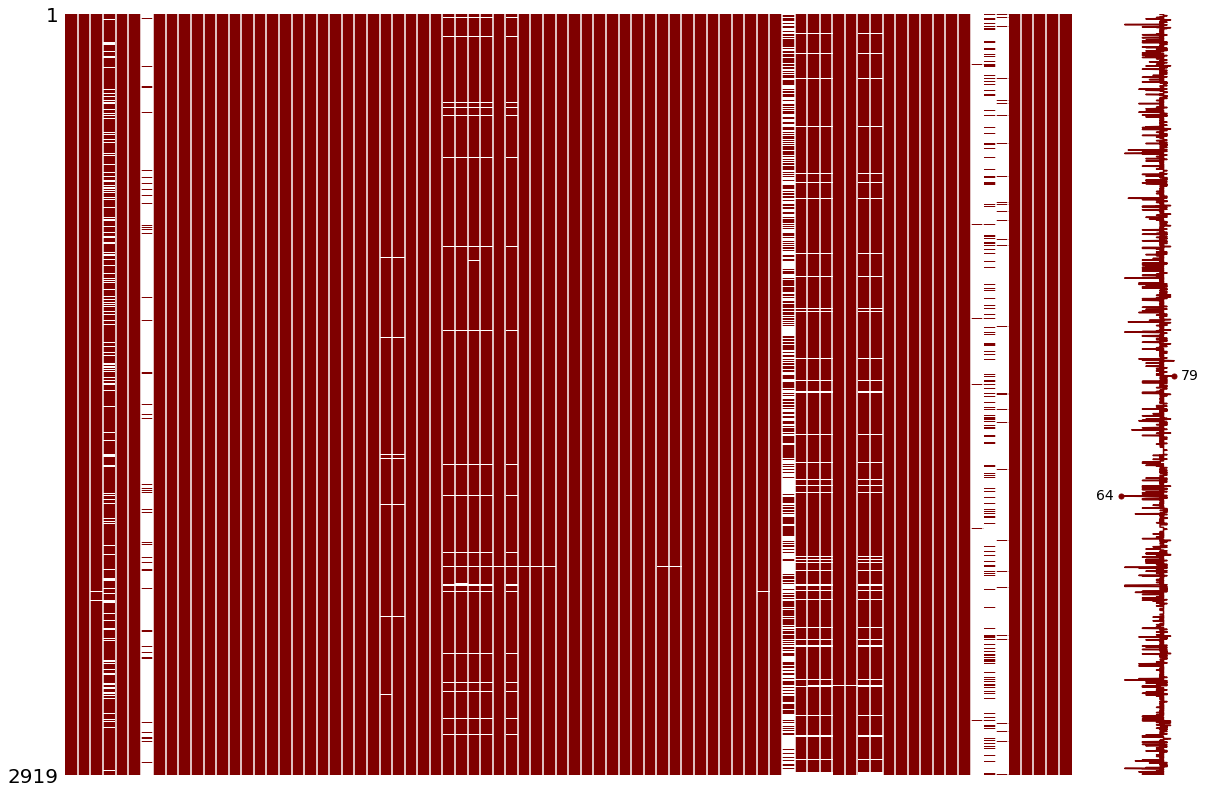

In [7]:
msno.matrix(df=both, figsize=(20,14), color=(0.5,0,0))

In [8]:
both_na = both.isnull().sum().sort_values(ascending = False)
both_na[both_na != 0]

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
Exterior1st        1
Exterior2nd        1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
SaleType           1
Electrical         1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64

### Missing Values: PoolQC
PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

In [9]:
both.filter(like = 'Pool', axis = 1).columns.values

array(['PoolArea', 'PoolQC'], dtype=object)

In [10]:
both[both.PoolQC.notnull()][['PoolArea', 'PoolQC']]

,PoolArea,PoolQC
197,512,Ex
810,648,Fa
1170,576,Gd
1182,555,Ex
1298,480,Gd
1386,519,Fa
1423,738,Gd
514,144,Ex
1113,228,Ex
1250,800,Gd


In [11]:
both[both.PoolArea != 0][["PoolArea", "PoolQC"]]

,PoolArea,PoolQC
197,512,Ex
810,648,Fa
1170,576,Gd
1182,555,Ex
1298,480,Gd
1386,519,Fa
1423,738,Gd
514,144,Ex
960,368,NaN
1043,444,NaN


In [12]:
both.loc[(both['PoolArea'] != 0) & (both['PoolQC'].isnull())][['PoolArea', 'PoolQC', 'OverallQual', 'OverallCond']]

,PoolArea,PoolQC,OverallQual,OverallCond
960,368,NaN,4,6
1043,444,NaN,6,5
1139,561,NaN,3,5


In [13]:
both['PoolQC'].value_counts()

Gd    4
Ex    4
Fa    2
Name: PoolQC, dtype: int64

In [14]:
both.groupby('PoolQC').agg({'OverallQual': ['min','mean', 'max']})

OverallQual          
               min  mean max
PoolQC                      
Ex               8  9.00  10
Fa               6  6.50   7
Gd               6  7.25  10

Especial Case: PoolQC will be filled in with 'Fa' when OverallQual is 3 or 4 and it will be filled in with 'Gd' when OverallQual is 6.

General Case: None

### Missing Values: MiscFeature
MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

In [15]:
both.filter(like = 'Misc', axis = 1).columns.values

array(['MiscFeature', 'MiscVal'], dtype=object)

In [16]:
both[both.MiscFeature.notnull()][['MiscFeature', 'MiscVal']].head()

,MiscFeature,MiscVal
5,Shed,700
7,Shed,350
16,Shed,700
17,Shed,500
51,Shed,400


In [17]:
both.loc[(both['MiscVal'] != 0) & (both['MiscFeature'].isnull())][['MiscFeature', 'MiscVal']]

,MiscFeature,MiscVal
1089,NaN,17000


In [18]:
both.groupby('MiscFeature').agg({'MiscVal': ['min','mean', 'max']})

MiscVal               
                min    mean    max
MiscFeature                       
Gar2           3000  8760.0  15500
Othr              0  3250.0   6500
Shed              0   763.8   4500
TenC           2000  2000.0   2000

Special Case: MiscFeature will be filled in with 'Gar2' when MiscVal is not 0.

General Case: None

### Missing Values: Alley
Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

In [19]:
both.loc[(both['Alley'].isnull())][['Alley', 'Street']].head()

,Alley,Street
0,NaN,Pave
1,NaN,Pave
2,NaN,Pave
3,NaN,Pave
4,NaN,Pave


No special cases

General Case: None

### Missing Values: Fence
Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

### Missing Values: FireplaceQu
FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

In [20]:
both.filter(like = 'Fireplace', axis = 1).columns.values

array(['Fireplaces', 'FireplaceQu'], dtype=object)

In [21]:
both.loc[(both['Fireplaces'] != 0) & (both['FireplaceQu'].isnull())][['Fireplaces', 'FireplaceQu']]

,Fireplaces,FireplaceQu


No special case

General case: None

### Missing Values: LotFrontage
LotFrontage: Linear feet of street connected to property

In [22]:
both.filter(like = 'Lot', axis = 1).columns.values

array(['LotFrontage', 'LotArea', 'LotShape', 'LotConfig'], dtype=object)

In [23]:
both.loc[(both['LotFrontage'].isnull())][['LotFrontage', 'LotArea', 'LotShape', 'LotConfig', 'Neighborhood']].head()

,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood
7,NaN,10382,IR1,Corner,NWAmes
12,NaN,12968,IR2,Inside,Sawyer
14,NaN,10920,IR1,Corner,NAmes
16,NaN,11241,IR1,CulDSac,NAmes
24,NaN,8246,IR1,Inside,Sawyer


Special Case: Mean by neighborhood

No general case

### Missing Values: Garage
GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
GarageYrBlt: Year garage was built
		
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
		
GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

In [24]:
both.filter(like = 'Garage', axis = 1).columns.values

array(['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond'], dtype=object)

In [25]:
both.loc[(both['GarageCond'].isnull()) & 
         ((both['GarageType'].notnull()) | 
           (both['GarageYrBlt'].notnull()) |
          (both['GarageFinish'].notnull()) |
          (both['GarageCars'] != 0) | 
          (both['GarageArea'] != 0) |
          (both['GarageQual'].notnull()))][['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
666,Detchd,NaN,NaN,1.0,360.0,NaN,NaN
1116,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
both.loc[(both['GarageCond'].isnull()) & 
         ((both['GarageType'].notnull()))][['YearBuilt', 'YearRemodAdd', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'OverallQual', 'OverallCond']]

,YearBuilt,YearRemodAdd,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,OverallQual,OverallCond
666,1910,1983,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,6,8
1116,1923,1999,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,5,6


In [27]:
# Fill in the GarageQual based in the OverallQual (5 and 6 -> Average and Above Average)
both['GarageQual'].value_counts()

TA    2604
Fa     124
Gd      24
Po       5
Ex       3
Name: GarageQual, dtype: int64

In [28]:
# Fill in the GarageQual based in the OverallQual (6 and 8 -> Above Average and Very Good)
both['GarageCond'].value_counts()

TA    2654
Fa      74
Gd      15
Po      14
Ex       3
Name: GarageCond, dtype: int64

Special case:

       GarageYrBlt	mean of the column
       GarageFinish	mode of the column
       GarageCars	mode of the column
       GarageArea	mean of the column
       GarageQual	based on the OverallQual
       GarageCond	based on the OverallCond

General cases:

       GarageType	None
       GarageFinish	None
       GarageQual	None
       GarageCond	None

### Missing Values: Basement
BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

In [29]:
both.filter(like = 'Bsmt', axis = 1).columns.values

array(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'], dtype=object)

In [30]:
basement = both[['Neighborhood', 'OverallQual', 'OverallCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']]
basement[((basement.isnull()).sum(axis=1) > 0) & ((basement.isnull()).sum(axis=1) < 5)]

,Neighborhood,OverallQual,OverallCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
332,NridgHt,8,5,Gd,TA,No,GLQ,1124.0,NaN,479.0,1603.0,3206.0,1.0,0.0
948,CollgCr,7,5,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,0.0,0.0
27,Somerst,8,5,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0
580,Veenker,8,9,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,1.0,0.0
725,Edwards,6,6,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,0.0,1.0
757,IDOTRR,4,7,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,0.0,0.0
758,IDOTRR,4,7,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,0.0,0.0
888,Somerst,5,5,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0
1064,CollgCr,5,7,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,0.0,0.0


Special cases:

       BsmtQual	     mode by neighborhood
       BsmtCond	     mode by neighborhood
       BsmtExposure	 mode by neighborhood
       BsmtFinType2	 mode by neighborhood

General cases:

       BsmtQual	     None
       BsmtCond	     None
       BsmtExposure	 None
       BsmtFinType1	 None
       BsmtFinSF1	 0
       BsmtFinType2	 None
       BsmtFinSF2	 0
       BsmtUnfSF	 0
       TotalBsmtSF	 0
       BsmtFullBath	 0
       BsmtHalfBath	 0

### Missing Values: MasVnrType
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

In [31]:
both.filter(like = 'MasVnr', axis = 1).columns.values

array(['MasVnrType', 'MasVnrArea'], dtype=object)

In [32]:
both.loc[(both['MasVnrType'].isnull()) & (both['MasVnrArea'].notnull())][['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
1150,NaN,198.0


No special case

General case: None

### Missing Values: MSZoning
MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

In [33]:
both.loc[(both['MSZoning'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,1916,30,NaN,109.0,21780,Grvl,NaN,Reg,Lvl,NaN,...,0,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal
756,2217,20,NaN,80.0,14584,Pave,NaN,Reg,Low,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml
790,2251,70,NaN,NaN,56600,Pave,NaN,IR1,Low,AllPub,...,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal
1444,2905,20,NaN,125.0,31250,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal


Special case: mode by neighborhood

No general case

### Missing Values: Utilities
Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only

In [34]:
both.loc[(both['Utilities'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,1916,30,NaN,109.0,21780,Grvl,NaN,Reg,Lvl,NaN,...,0,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal
485,1946,20,RL,NaN,31220,Pave,NaN,IR1,Bnk,NaN,...,0,0,NaN,NaN,Shed,750,5,2008,WD,Normal


General case: mode

### Missing Values: Functional
Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

In [35]:
both.loc[(both['Functional'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
756,2217,20,NaN,80.0,14584,Pave,NaN,Reg,Low,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml
1013,2474,50,RM,60.0,10320,Pave,Grvl,Reg,Lvl,AllPub,...,84,0,NaN,NaN,NaN,0,9,2007,COD,Abnorml


General case: mode

### Missing Values: Exterior1st
Exterior1st: Exterior covering on house

Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

In [36]:
both.filter(like = 'Exterior', axis = 1).columns.values

array(['Exterior1st', 'Exterior2nd'], dtype=object)

In [37]:
both.loc[(both['Exterior1st'].isnull())][['Exterior1st', 'Exterior2nd']]

,Exterior1st,Exterior2nd
691,NaN,NaN


General case: mode

### Missing Values: SaleType
SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other

In [38]:
both.filter(like = 'Sale', axis = 1).columns.values

array(['SaleType', 'SaleCondition'], dtype=object)

In [39]:
both.loc[(both['SaleType'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1029,2490,20,RL,85.0,13770,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,10,2007,NaN,Normal


General case: mode

### Missing Values: Electrical
Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

In [40]:
both.loc[(both['Electrical'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal


General case: mode

### Missing Values: KitchenQual
KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

In [41]:
both.loc[(both['KitchenQual'].isnull())][['KitchenQual', 'OverallQual']]

,KitchenQual,OverallQual
95,NaN,5


General case: mode

# Filling in Missing Values

In [42]:
# Copy of the original dataframes
train = train_orig.copy()
test = test_orig.copy()

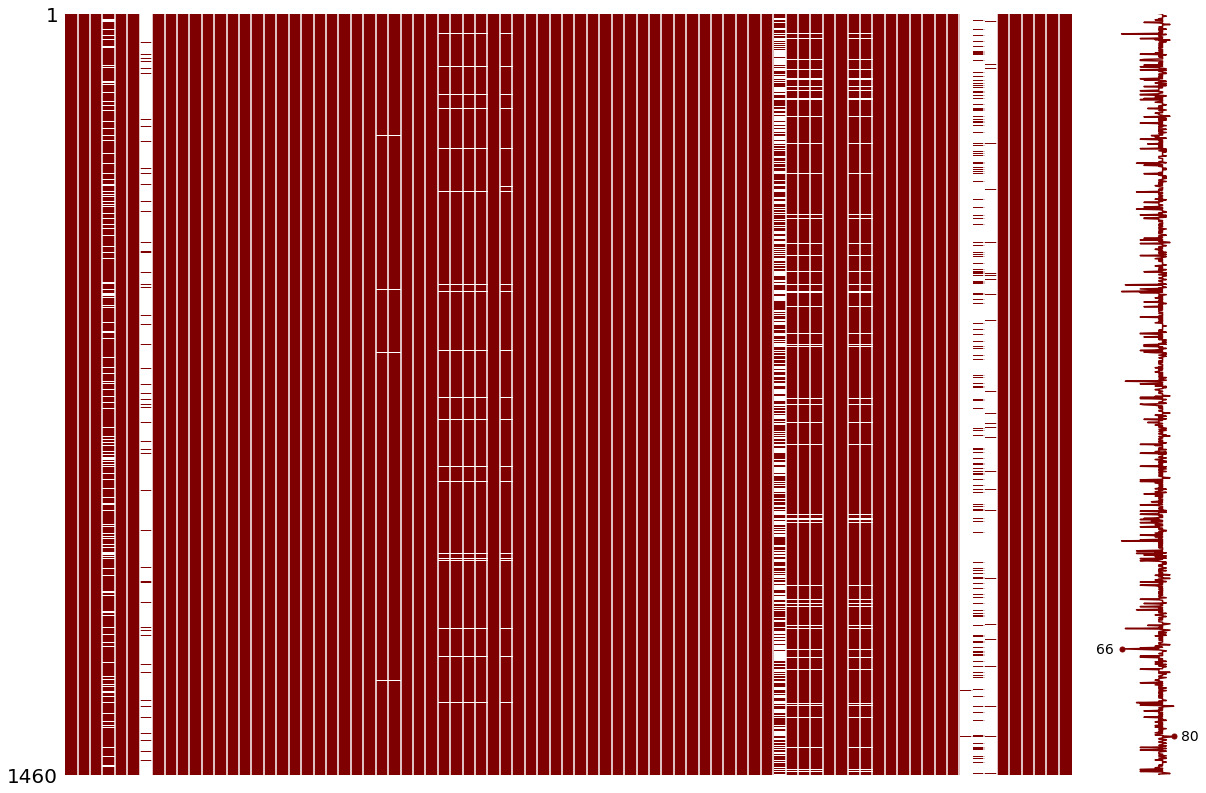

In [43]:
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

In [44]:
neigh_groupby = both.groupby('Neighborhood')[['LotFrontage']].mean()

bynbrhd = both[['Neighborhood', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'MasVnrType', 'MasVnrArea', 'MSZoning']]
bynbrhd = bynbrhd.dropna()
bynbrhd1 = bynbrhd.set_index('Neighborhood')
neighborhoods = bynbrhd1.index.unique()
neighcolumns = bynbrhd1.columns.values
neighs = []
modes = []
varss = []
for x in neighborhoods:
    a = bynbrhd1.loc[x]
    for y in neighcolumns:
        b = a[y].mode()[0]
        neighs.append(x)
        modes.append(b)
        varss.append(y)
        nb = pd.DataFrame(
            {'Neighborhood': neighs,
             'Mode': modes,
             'Variable': varss
            })

In [45]:
def fill_none(df, col):
    #########################################################
    # Fill the NaN value with None                          #
    # Input: dataframe and name of the column               #
    # Output: column of the dataframe filled in with None   #
    #########################################################
    return (df.fillna({col: "None"}))

def fill_0(df, col):
    #########################################################
    # Fill the NaN value with zero                          #
    # Input: dataframe and name of the column               #
    # Output: column of the dataframe filled in with zero   #
    #########################################################
    return (df.fillna({col: 0}))

def fill_mode(df, col):
    #########################################################
    # Fill the NaN value with zero                          #
    # Input: dataframe and name of the column               #
    # Output: column of the dataframe filled in with zero   #
    #########################################################
    return (df.fillna({col: both[col].mode()[0]}))

In [46]:
# PoolQC
ids = test.loc[(test['PoolArea'] != 0) & (test['PoolQC'].isnull()) & (test['OverallQual'] < 5)].index
for row in ids:
    test.loc[row, "PoolQC"] = 'Fa'

ids = test.loc[(test['PoolArea'] != 0) & (test['PoolQC'].isnull()) & (test['OverallQual'] > 5)].index
for row in ids:
    test.loc[row, "PoolQC"] = 'Gd'

# MiscFeature
ids = test.loc[(test['MiscVal'] != 0) & (test['MiscFeature'].isnull())].index
for row in ids:
    test.loc[row, "MiscFeature"] = 'Gar2'

# LotFrontage
ids = train.loc[(train['LotFrontage'].isnull())].index
for row in ids:
    neighborhood = train.loc[row, 'Neighborhood']
    train.loc[row, "LotFrontage"] = neigh_groupby.loc[neighborhood, 'LotFrontage']

ids = test.loc[(test['LotFrontage'].isnull())].index
for row in ids:
    neighborhood = test.loc[row, 'Neighborhood']
    test.loc[row, "LotFrontage"] = neigh_groupby.loc[neighborhood, 'LotFrontage']

# Garage
ids = test.loc[(test['GarageCond'].isnull()) & (test['GarageType'].notnull())].index
for row in ids:
    test.loc[row, "GarageYrBlt"] = round(both['GarageYrBlt'].mean())
    test.loc[row, "GarageFinish"] = both['GarageFinish'].mode()[0]
    test.loc[row, "GarageQual"] = 'TA'

ids = test.loc[(test['GarageCond'].isnull()) & (test['GarageType'].notnull()) & (test['OverallCond'] == 8)].index
for row in ids:
    test.loc[row, "GarageCond"] = 'Gd'
    
ids = test.loc[(test['GarageCond'].isnull()) & (test['GarageType'].notnull()) & (test['GarageCars'].isnull())].index
for row in ids:
    test.loc[row, "GarageCars"] = both['GarageCars'].mode()[0]
    test.loc[row, "GarageArea"] = both['GarageArea'].median()
    test.loc[row, "GarageCond"] = 'TA'
    
# Basement
ids = test.loc[(test['BsmtQual'].isnull()) & (test['BsmtCond'].notnull())].index
for row in ids:
    neighborhood = test.loc[row, "Neighborhood"]
    test.loc[row, "BsmtQual"] = nb.loc[(nb["Neighborhood"] == neighborhood) & (nb["Variable"] == "BsmtQual")]['Mode'].values[0]

ids = test.loc[(test['BsmtCond'].isnull()) & (test['BsmtQual'].notnull())].index
for row in ids:
    neighborhood = test.loc[row, "Neighborhood"]
    test.loc[row, "BsmtCond"] = nb.loc[(nb["Neighborhood"] == neighborhood) & (nb["Variable"] == "BsmtCond")]['Mode'].values[0]

ids = test.loc[(test['BsmtExposure'].isnull()) & (test['BsmtQual'].notnull())].index
for row in ids:
    neighborhood = test.loc[row, "Neighborhood"]
    test.loc[row, "BsmtExposure"] = nb.loc[(nb["Neighborhood"] == neighborhood) & (nb["Variable"] == "BsmtExposure")]['Mode'].values[0]
    
ids = train.loc[(train['BsmtExposure'].isnull()) & (train['BsmtQual'].notnull())].index
for row in ids:
    neighborhood = train.loc[row, "Neighborhood"]
    train.loc[row, "BsmtExposure"] = nb.loc[(nb["Neighborhood"] == neighborhood) & (nb["Variable"] == "BsmtExposure")]['Mode'].values[0]
    
ids = train.loc[(train['BsmtFinType2'].isnull()) & (train['BsmtQual'].notnull())].index
for row in ids:
    neighborhood = train.loc[row, "Neighborhood"]
    train.loc[row, "BsmtFinType2"] = nb.loc[(nb["Neighborhood"] == neighborhood) & (nb["Variable"] == "BsmtFinType2")]['Mode'].values[0]

# MSZoning
ids = train.loc[(train['MSZoning'].isnull())].index
for row in ids:
    neighborhood = train.loc[row, "Neighborhood"]
    train.loc[row, "MSZoning"] = nb.loc[(nb["Neighborhood"] == neighborhood) & (nb["Variable"] == "BsmtFinType2")]['Mode'].values[0]

ids = test.loc[(test['MSZoning'].isnull())].index
for row in ids:
    neighborhood = test.loc[row, "Neighborhood"]
    test.loc[row, "MSZoning"] = nb.loc[(nb["Neighborhood"] == neighborhood) & (nb["Variable"] == "BsmtFinType2")]['Mode'].values[0]
    

In [47]:
# Filling in with Nome
ids = ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "BsmtCond", "BsmtExposure", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType")
for col in ids:
    train = fill_none(train, col)
    test = fill_none(test, col)

# Filling in with 0
ids = ("GarageYrBlt", "BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea")
for col in ids:
    train = fill_0(train, col)
    test = fill_0(test, col)

# Filling in with Mode value
ids = ("Functional", "Utilities", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "KitchenQual")
for col in ids:
    train = fill_mode(train, col)
    test = fill_mode(test, col)



In [48]:
# Are there ony more missing values in the train dataframe?
train_na = train.isnull().sum().sort_values(ascending = False)
train_na[train_na != 0]

Series([], dtype: int64)

In [49]:
# Are there ony more missing values in the test dataframe?
test_na = test.isnull().sum().sort_values(ascending = False)
test_na[test_na != 0]

Series([], dtype: int64)

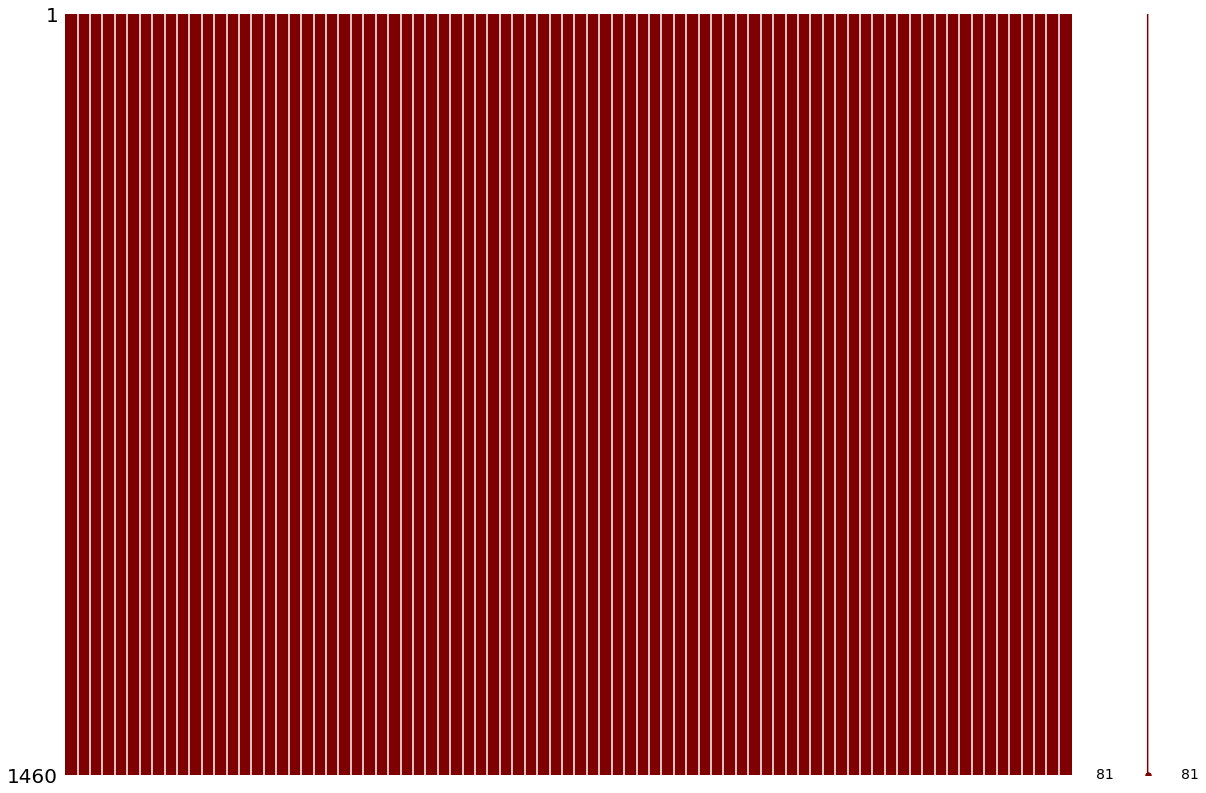

In [50]:
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

# Outilier

In [51]:
# #bivariate analysis saleprice/grlivarea
# var = 'GrLivArea'
# data = pd.concat([train['SalePrice'], train[var]], axis=1)
# data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [52]:
# train[train['GrLivArea'] > 4500]

In [53]:
# # deleting rows which GRLivArea is greater than 4500
# train = train[train['GrLivArea'] < 4500]

In [54]:
# var = 'GrLivArea'
# data = pd.concat([train['SalePrice'], train[var]], axis=1)
# data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

# Concatenating Features

In [55]:
train['Total_sqr_footage'] = (train['BsmtFinSF1'] + train['BsmtFinSF2'] +
                                 train['1stFlrSF'] + train['2ndFlrSF'])

train['Total_Bathrooms'] = (train['FullBath'] + (0.5*train['HalfBath']) + 
                               train['BsmtFullBath'] + (0.5*train['BsmtHalfBath']))

train['Total_porch_sf'] = (train['OpenPorchSF'] + train['3SsnPorch'] +
                              train['EnclosedPorch'] + train['ScreenPorch'] +
                             train['WoodDeckSF'])

train = train.drop(columns=['BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'FullBath','HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF', 'LandSlope', 'Exterior2nd'])

In [56]:
test['Total_sqr_footage'] = (test['BsmtFinSF1'] + test['BsmtFinSF2'] +
                                 test['1stFlrSF'] + test['2ndFlrSF'])

test['Total_Bathrooms'] = (test['FullBath'] + (0.5*test['HalfBath']) + 
                               test['BsmtFullBath'] + (0.5*test['BsmtHalfBath']))

test['Total_porch_sf'] = (test['OpenPorchSF'] + test['3SsnPorch'] +
                              test['EnclosedPorch'] + test['ScreenPorch'] +
                             test['WoodDeckSF'])

test = test.drop(columns=['BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'FullBath','HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF', 'LandSlope', 'Exterior2nd'])

# Deleting columns 

In [57]:
# MiscFeature,Fence,Utilities
train = train.drop(["Id", "Fence", "MiscFeature", "Utilities"], axis=1)
test = test.drop(["Id", "Fence", "MiscFeature", "Utilities"], axis=1)

# Correlation

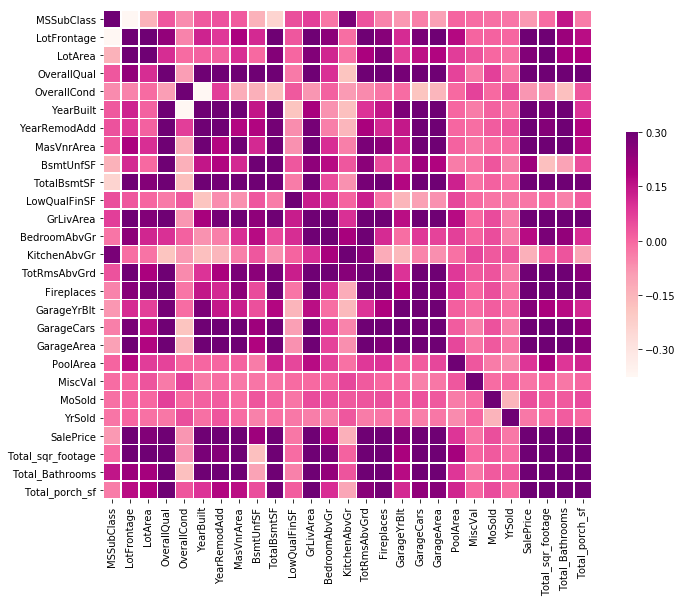

In [58]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cmap = 'RdPu', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

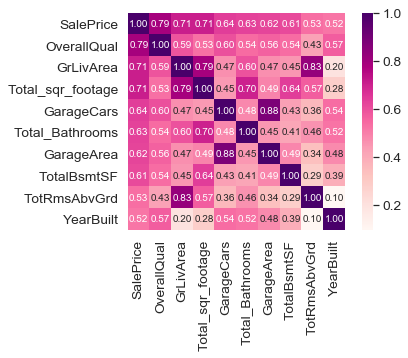

In [59]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap='RdPu' ,cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

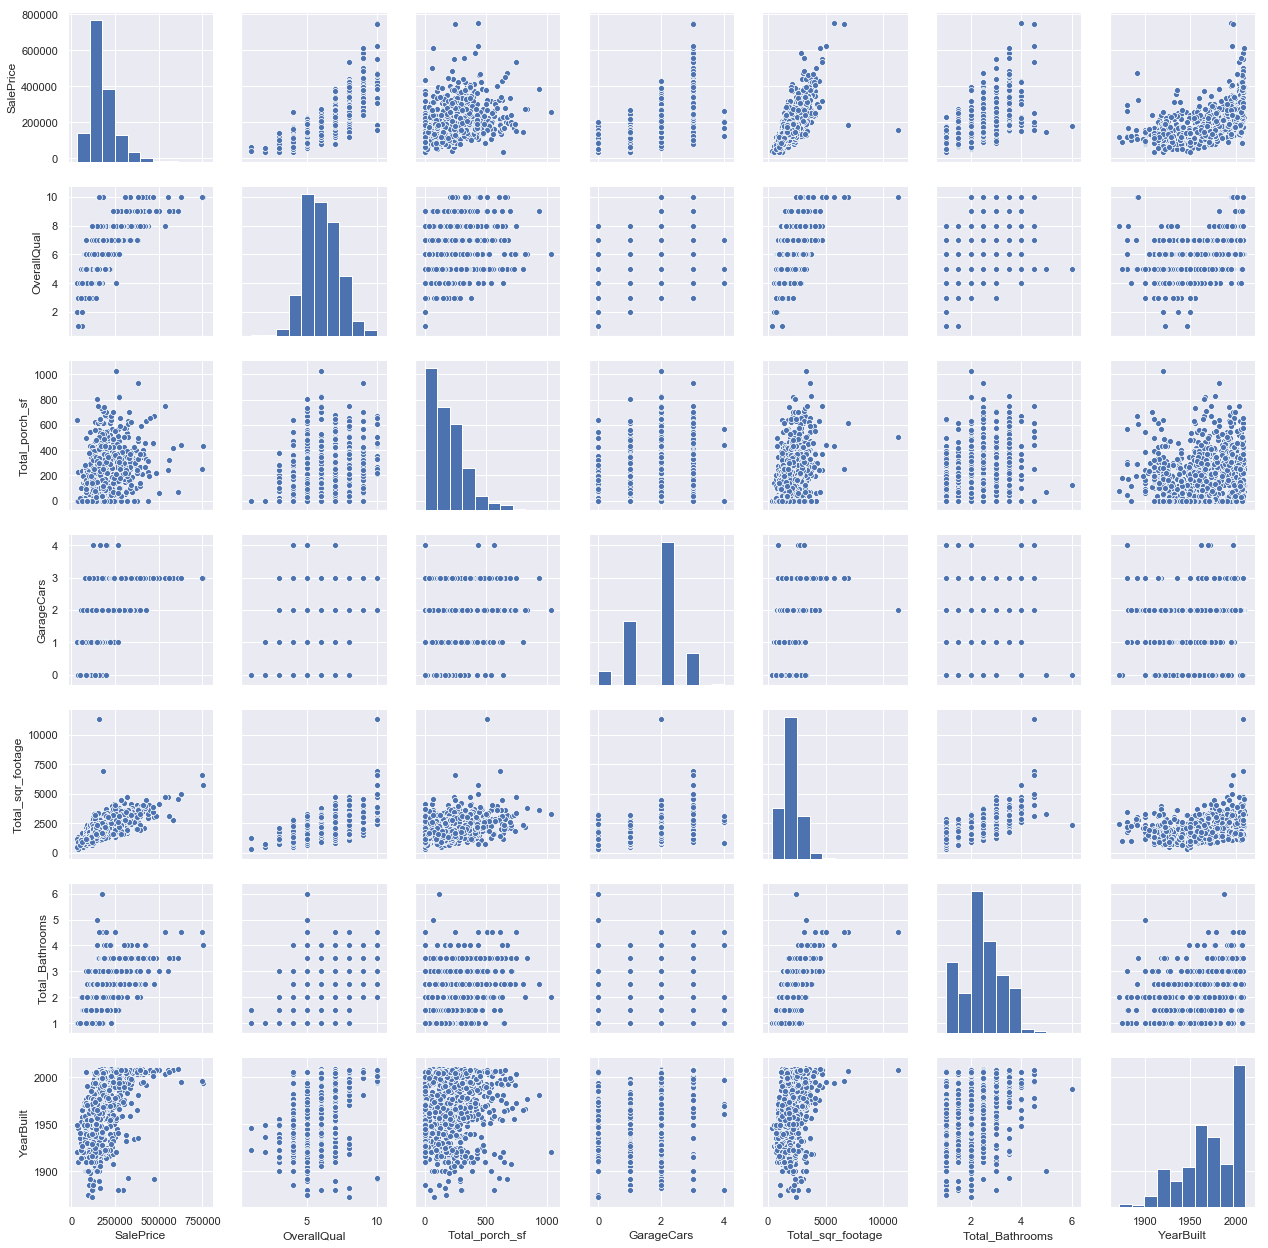

In [60]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'Total_porch_sf', 'GarageCars', 'Total_sqr_footage', 'Total_Bathrooms', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

In [61]:
train.corr()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtUnfSF,TotalBsmtSF,...,GarageCars,GarageArea,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Total_sqr_footage,Total_Bathrooms,Total_porch_sf
MSSubClass,1.000000,-0.374043,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.140759,-0.238518,...,-0.040110,-0.098672,0.008283,-0.007683,-0.013585,-0.021407,-0.084284,-0.006936,0.151048,-0.034807
LotFrontage,-0.374043,1.000000,0.344300,0.234958,-0.045133,0.125216,0.085087,0.189758,0.114832,0.377072,...,0.280504,0.335066,0.173850,0.009162,0.010052,0.005832,0.348056,0.407329,0.221591,0.164804
LotArea,-0.139781,0.344300,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,-0.002618,0.260833,...,0.154871,0.180403,0.077672,0.038068,0.001205,-0.014261,0.263843,0.327672,0.204764,0.185256
OverallQual,0.032628,0.234958,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.308159,0.537808,...,0.600671,0.562022,0.065166,-0.031406,0.070815,-0.027347,0.790982,0.533425,0.541063,0.306097
OverallCond,-0.059316,-0.045133,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.136841,-0.171098,...,-0.185758,-0.151521,-0.001985,0.068777,-0.003511,0.043950,-0.077856,-0.074560,-0.174032,0.035280
YearBuilt,0.027850,0.125216,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.149040,0.391452,...,0.537850,0.478954,0.004950,-0.034383,0.012398,-0.013618,0.522897,0.283450,0.524298,0.096577
YearRemodAdd,0.040581,0.085087,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.181133,0.291066,...,0.420622,0.371600,0.005829,-0.010286,0.021490,0.035743,0.507101,0.260606,0.443719,0.179338
MasVnrArea,0.023573,0.189758,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.113862,0.360067,...,0.361945,0.370884,0.011928,-0.029512,-0.006723,-0.008317,0.472614,0.406854,0.314248,0.162687
BsmtUnfSF,-0.140759,0.114832,-0.002618,0.308159,-0.136841,0.149040,0.181133,0.113862,1.000000,0.415360,...,0.214175,0.183303,-0.035092,-0.023837,0.034888,-0.041258,0.214479,-0.174117,-0.104496,0.048726
TotalBsmtSF,-0.238518,0.377072,0.260833,0.537808,-0.171098,0.391452,0.291066,0.360067,0.415360,1.000000,...,0.434585,0.486665,0.126053,-0.018479,0.013196,-0.014969,0.613581,0.640590,0.414468,0.290030


In [62]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice            1.000000
OverallQual          0.790982
GrLivArea            0.708624
Total_sqr_footage    0.708047
GarageCars           0.640409
Total_Bathrooms      0.631731
GarageArea           0.623431
TotalBsmtSF          0.613581
TotRmsAbvGrd         0.533723
YearBuilt            0.522897
YearRemodAdd         0.507101
MasVnrArea           0.472614
Fireplaces           0.466929
Total_porch_sf       0.390993
LotFrontage          0.348056
LotArea              0.263843
GarageYrBlt          0.261366
BsmtUnfSF            0.214479
BedroomAbvGr         0.168213
PoolArea             0.092404
MoSold               0.046432
MiscVal             -0.021190
LowQualFinSF        -0.025606
YrSold              -0.028923
OverallCond         -0.077856
MSSubClass          -0.084284
KitchenAbvGr        -0.135907
Name: SalePrice, dtype: float64


# Log SalePrice

In [63]:
train["SalePrice"].describe()
# No negative price

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

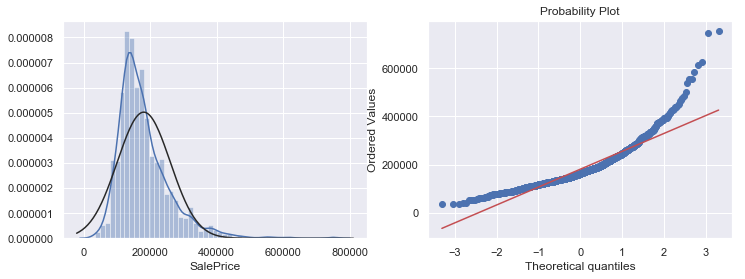

In [64]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(train.SalePrice, fit=norm);
plt.subplot(1,2,2)
_= stats.probplot(train.SalePrice, plot=plt)

In [65]:
y = np.log(train.SalePrice + 1)

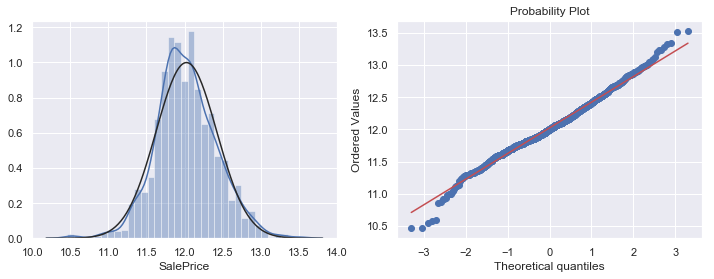

In [66]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(y, fit=norm);
plt.subplot(1,2,2)
_= stats.probplot(y, plot=plt)

# Dummify

In [67]:
print("train : " + str(train.shape))
print("test  : " + str(test.shape))

train : (1460, 65)
test  : (1459, 64)


In [68]:
def dummify(df):
    col_to_dummify = df.dtypes[df.dtypes == object].index
    dummified = df
    for col in col_to_dummify:
        dummies = pd.get_dummies(dummified[col], prefix=col)
        max_freq = dummies.sum(axis = 0)
        for name in max_freq.index:
            if max_freq[name] == max_freq.max():
                drop_col = name
        dummified = pd.concat((dummies.drop(drop_col, axis = 1), dummified.drop(col, axis = 1)), axis=1)
    return (dummified)

In [69]:
train_dummified = dummify(train)
test_dummified = dummify(test)

In [70]:
print("train : " + str(train_dummified.shape))
print("test  : " + str(test_dummified.shape))

train : (1460, 224)
test  : (1459, 210)


In [74]:
train_all = train_dummified
y = np.log(train_dummified.SalePrice + 1)
train_dummified = train_dummified.drop("SalePrice", axis = 1)

### Are we using this?

In [75]:
# # Differentiate numerical features (minus the target) and categorical features
# categorical_features = test_dummified.select_dtypes(include = ["object"]).columns
# numerical_features = test_dummified.select_dtypes(exclude = ["object"]).columns
# #numerical_features = numerical_features.drop("SalePrice")
# print("Numerical features : " + str(len(numerical_features)))
# print("Categorical features : " + str(len(categorical_features)))
# train_num = test_dummified[numerical_features]
# train_cat = test_dummified[categorical_features]

In [76]:
# #log transformation for all skewed variables 
# skewness = train_num.apply(lambda x: skew(x))
# skewness = skewness[abs(skewness) > 0.5]
# print(str(skewness.shape[0]) + " skewed numerical features to log transform")
# skewed_features = skewness.index
# train_num[skewed_features] = np.log1p(train_num[skewed_features])

### Feature Selection - Are we using this?

In [77]:
lsr = Lasso(alpha=0.00047)
lsr.fit(train_dummified, y)
np.sqrt(-cross_val_score(lsr, train_dummified, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.13856183710880765

In [78]:
coef = pd.Series(lsr.coef_, index = train_dummified.columns)

In [79]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 113 variables and eliminated the other 110 variables


In [80]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

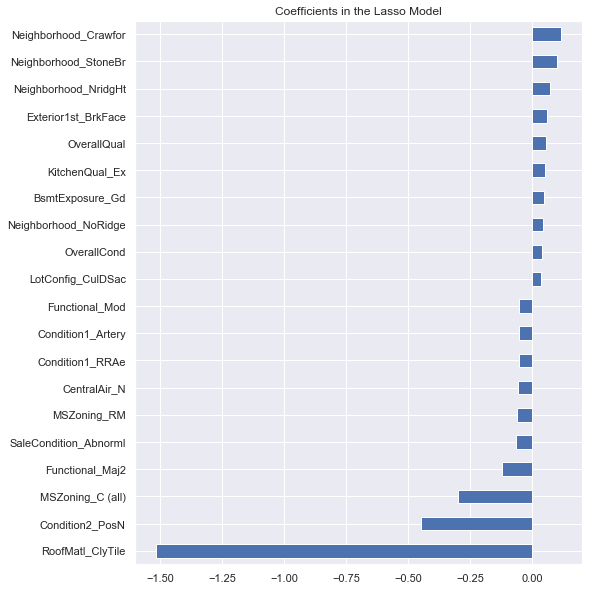

In [81]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

# Outliers using Ridge and ElasticNet

In [82]:
rr = Ridge(alpha=10)
rr.fit(train_dummified, y)
np.sqrt(-cross_val_score(rr, train_dummified, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.9844945532890019

In [83]:
y_pred = rr.predict(train_dummified)
resid = y - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers1 = np.where(abs(z) > abs(z).std() * 3)[0]
outliers1

array([  21,   30,   46,   48,   56,   74,   75,   84,   88,   90,  111,
        125,  154,  156,  185,  210,  260,  277,  289,  307,  312,  313,
        324,  335,  348,  357,  375,  381,  383,  407,  417,  467,  489,
        520,  523,  533,  545,  565,  569,  573,  607,  609,  632,  636,
        653,  676,  687,  705,  711,  726,  729,  749,  778,  807,  843,
        861,  868,  881,  897,  939,  970, 1002, 1009, 1018, 1035, 1068,
       1076, 1106, 1116, 1124, 1129, 1132, 1144, 1168, 1175, 1179, 1192,
       1211, 1218, 1223, 1230, 1234, 1245, 1247, 1248, 1268, 1292, 1298,
       1301, 1322, 1324, 1334, 1353, 1382, 1397, 1408, 1432, 1448, 1454])

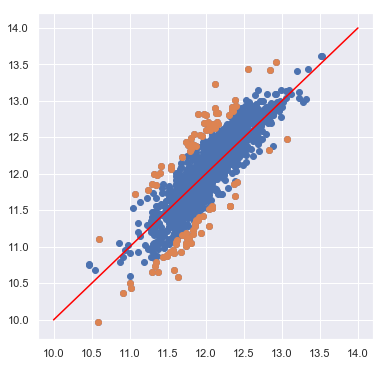

In [84]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred)
plt.scatter(y.iloc[outliers1], y_pred[outliers1])
plt.plot(range(10, 15), range(10, 15), color="red")

In [85]:
er = ElasticNet(alpha=0.001, l1_ratio=0.58)
er.fit(train_dummified, y)
np.sqrt(-cross_val_score(rr, train_dummified, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.8475486510478101

In [86]:
y_pred = er.predict(train_dummified)
resid = y - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers2 = np.where(abs(z) > abs(z).std() * 3)[0]
outliers2

array([  30,   66,   88,  142,  277,  328,  410,  462,  495,  523,  529,
        533,  588,  628,  632,  666,  681,  688,  710,  714,  728,  774,
        803,  812,  874,  885,  898,  916,  968,  970, 1062, 1168, 1181,
       1211, 1298, 1324, 1423, 1432, 1453])

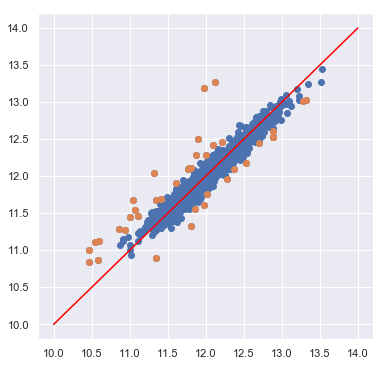

In [87]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred)
plt.scatter(y.iloc[outliers2], y_pred[outliers2])
plt.plot(range(10, 15), range(10, 15), color="red")

In [88]:
outliers = []
for i in outliers1:
    for j in outliers2:
        if i == j:
            outliers.append(i)
outliers

[30, 88, 277, 523, 533, 632, 970, 1168, 1211, 1298, 1324, 1432]

In [89]:
# print("Previous shape: " + str(train.shape))
# for i in outliers2:
#     train = train.drop(i)
# print("Current shape: " + str(train.shape))

In [90]:
train = train.drop([30,
 66,
 70,
 88,
 142,
 185,
 218,
 277,
 328,
 410,
 431,
 457,
 462,
 479,
 495,
 528,
 532,
 559,
 580,
 587,
 627,
 631,
 657,
 661,
 665,
 680,
 687,
 709,
 713,
 727,
 737,
 773,
 802,
 811,
 873,
 884,
 915,
 967,
 969,
 1061,
 1121,
 1180,
 1210,
 1322,
 1335,
 1430,
 1451])

In [91]:
train_dummified = dummify(train)

In [92]:
print("train : " + str(train_dummified.shape))
print("test  : " + str(test_dummified.shape))

train : (1413, 224)
test  : (1459, 210)


Verifying which columns are differents and delete them

In [93]:
col_test = list(test_dummified.columns.values)
col_train = list(train_dummified.columns.values)

index = 0
i = 0
not_equal = []

for col in col_train:
    for col2 in col_test:
        if (col == col2 or col == "SalePrice"):
            index += 1
    if index == 0:
        not_equal.append(col)
    index = 0
    
i = 0    
for col in col_test:
    for col2 in col_train:
        if col == col2:
            index += 1
    if index == 0:
        not_equal.append(col)
    index = 0

In [94]:
for col in not_equal:
    col_name = col.split("_")[0]
    drop_col = list(train_dummified.filter(like = col_name, axis = 1).columns.values)
    train_dummified = train_dummified.drop(drop_col, axis=1)
    drop_col_test = list(test_dummified.filter(like = col_name, axis = 1).columns.values)
    test_dummified = test_dummified.drop(drop_col_test, axis=1)

In [95]:
print("train : " + str(train_dummified.shape))
print("test  : " + str(test_dummified.shape))

train : (1413, 161)
test  : (1459, 160)


In [96]:
y = np.log(train_dummified.SalePrice + 1)
train_dummified = train_dummified.drop("SalePrice", axis = 1)

# Modeling

In [97]:
gbr = GradientBoostingRegressor(max_depth=4, n_estimators=150)
gbr.fit(train_dummified, y)
np.sqrt(-cross_val_score(gbr, train_dummified, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.11795532803440997

In [98]:
xgbr = XGBRegressor(max_depth=5, n_estimators=400)
xgbr.fit(train_dummified, y)
np.sqrt(-cross_val_score(xgbr, train_dummified, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.11972087780832978

In [99]:
lsr = Lasso(alpha=0.00047)
lsr.fit(train_dummified, y)
np.sqrt(-cross_val_score(lsr, train_dummified, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.13740232229168098

In [100]:
rr = Ridge(alpha=13)
rr.fit(train_dummified, y)
np.sqrt(-cross_val_score(rr, train_dummified, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.13705133143643847

In [101]:
train_predict = 0.1 * gbr.predict(train_dummified) + 0.3 * xgbr.predict(train_dummified) + 0.3 * lsr.predict(train_dummified) + 0.3 * rr.predict(train_dummified)

In [102]:
train_predict

array([12.23799266, 12.15987249, 12.27498879, ..., 12.4583358 ,
       11.85184093, 11.93105021])

# Predicting

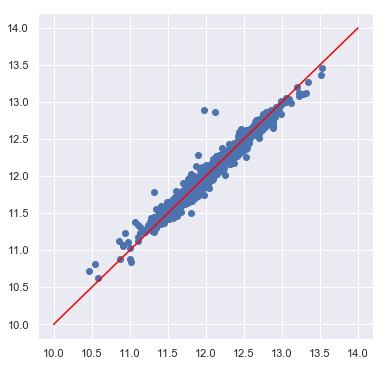

In [103]:
q1 = pd.DataFrame(train_predict).quantile(0.0042)
pre_df = pd.DataFrame(train_predict)
pre_df["SalePrice"] = train_predict
pre_df = pre_df[["SalePrice"]]
pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] = pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] *0.99
train_predict = np.array(pre_df.SalePrice)
plt.figure(figsize=(6, 6))
plt.scatter(y, train_predict)
plt.plot(range(10, 15), range(10, 15), color="red")

In [104]:
sample_submission = pd.read_csv("../data/sample_submission.csv")

In [105]:
arq_name = "2.csv"
test_predict = 0.1 * gbr.predict(test_dummified) + 0.3 * xgbr.predict(test_dummified) + 0.3 * lsr.predict(test_dummified) + 0.3 * rr.predict(test_dummified)
q1 = pd.DataFrame(test_predict).quantile(0.0042)
pre_df = pd.DataFrame(test_predict)
pre_df["SalePrice"] = test_predict
pre_df = pre_df[["SalePrice"]]
pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] = pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] *0.96
test_predict = np.array(pre_df.SalePrice)
sample_submission["SalePrice"] = np.exp(test_predict)-1
sample_submission.to_csv("../data/" + arq_name, index=False)